<a href="https://colab.research.google.com/github/Doradux/IABD-Course/blob/main/SAA/correlacion_y_colinealidad/prediccion_precio_coches_sklearn_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [214]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn import preprocessing


# mostrar todas las columnas de un df
pd.set_option('display.max_columns', None)

# Importar csv y tratar nulos

In [215]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data"
column_names = ["symboling", "normalized_losses", "make", "fuel_type", "aspiration","num_doors", "body_style", "drive_wheels", "engine_location", "wheel_base",	"length", "width", "height", "curb_weight", "engine_type", "num_cylinders","engine_size", "fuel_system", "bore", "stroke", "compression_ratio","horsepower", "peak_rpm", "city_mpg", "highway_mpg", "price"]
df = pd.read_csv(url, names=column_names, na_values="?")  # "?" indica valores faltantes
df

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0
201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0
202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0
203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0


## Compruebo nulos

In [216]:
df.isnull().sum()[df.isnull().sum() > 0]

,0
normalized_losses,41
num_doors,2
bore,4
stroke,4
horsepower,2
peak_rpm,2
price,4


## Compruebo la correlacion de la columna "normalized_losses" al ser la que mas nulos contiene para averiguar su impacto con la variable objetivo

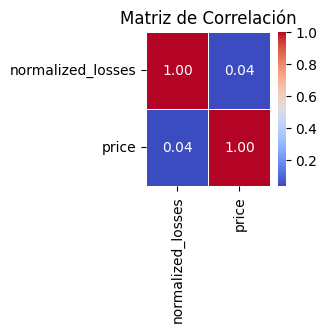

In [217]:
df_nl = df[["normalized_losses", "price"]]
correlation_matrix = df_nl.corr()**2

plt.figure(figsize=(2, 2))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt="0.2f")

plt.title("Matriz de Correlación")
plt.show()

## Eliminamos la columna al ver que no tiene ningun tipo de impacto, 0.04/1, y eliminamos los nulos

In [218]:
shape_antes = df.shape[0]
print(f"Rows antes de la limpieza: {shape_antes}")
df = df.drop(columns=["normalized_losses"])
df = df.dropna()
shape_despues = df.shape[0]
print(f"Rows despues de la limpieza: {shape_despues}")
print(f"Hemos eliminado un total de {shape_antes - shape_despues} datos")
df = df.reset_index(drop=True)

Rows antes de la limpieza: 205
Rows despues de la limpieza: 193
Hemos eliminado un total de 12 datos


## Con esto tan solo hemos eliminado 12 registros

# Ej1. Modelo de prediccion sin alterara los datos

## LabelEncoder a cada columna que no sea numerica

In [219]:
string_columns = df.select_dtypes(include=['object']).columns

X = df.drop(columns=['price'])
y = df['price']

label_encoder = preprocessing.LabelEncoder()

X_encoded = X.copy()

for col in string_columns:
    X_encoded[col] = label_encoder.fit_transform(X_encoded[col])

X_encoded

,symboling,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
0,3,0,1,0,1,0,2,0,88.6,168.8,64.1,48.8,2548,0,2,130,4,3.47,2.68,9.0,111.0,5000.0,21,27
1,3,0,1,0,1,0,2,0,88.6,168.8,64.1,48.8,2548,0,2,130,4,3.47,2.68,9.0,111.0,5000.0,21,27
2,1,0,1,0,1,2,2,0,94.5,171.2,65.5,52.4,2823,4,3,152,4,2.68,3.47,9.0,154.0,5000.0,19,26
3,2,1,1,0,0,3,1,0,99.8,176.6,66.2,54.3,2337,2,2,109,4,3.19,3.40,10.0,102.0,5500.0,24,30
4,2,1,1,0,0,3,0,0,99.4,176.6,66.4,54.3,2824,2,1,136,4,3.19,3.40,8.0,115.0,5500.0,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,-1,20,1,0,0,3,2,0,109.1,188.8,68.9,55.5,2952,2,2,141,4,3.78,3.15,9.5,114.0,5400.0,23,28
189,-1,20,1,1,0,3,2,0,109.1,188.8,68.8,55.5,3049,2,2,141,4,3.78,3.15,8.7,160.0,5300.0,19,25
190,-1,20,1,0,0,3,2,0,109.1,188.8,68.9,55.5,3012,4,3,173,4,3.58,2.87,8.8,134.0,5500.0,18,23
191,-1,20,0,1,0,3,2,0,109.1,188.8,68.9,55.5,3217,2,3,145,2,3.01,3.40,23.0,106.0,4800.0,26,27


## Ejecutar modelo

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

ej1_mse = mean_squared_error(y_test, y_pred)
ej1_r2 = r2_score(y_test, y_pred)
ej1_rmse = np.sqrt(ej1_mse)

# print(f'mse: {mse}')
print(f'r2: {ej1_r2}')
print(f'rmse: {ej1_rmse}')

r2: 0.8498199133751998
rmse: 4108.098565288595


# Ej 2. Solo numericas correlativas

## Seleccionar numericas

In [221]:
df_2 = df.select_dtypes(include=['float64', 'int64'])
df_2.dtypes

,0
symboling,int64
wheel_base,float64
length,float64
width,float64
height,float64
curb_weight,int64
engine_size,int64
bore,float64
stroke,float64
compression_ratio,float64


## Mostrar correlacion

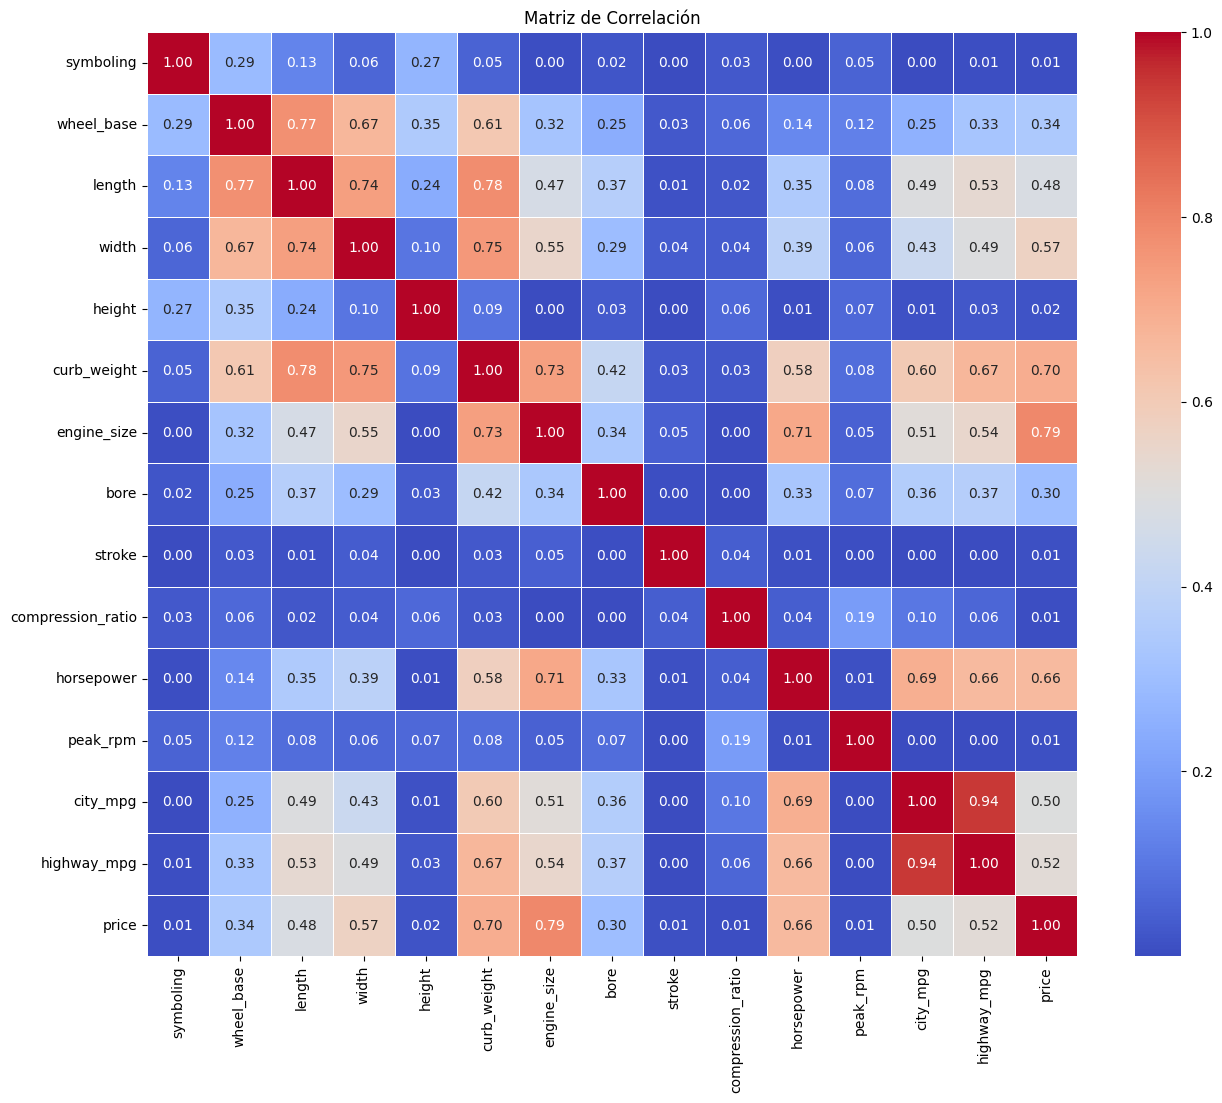

In [222]:
correlation_matrix = df_2.corr()**2

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt="0.2f")

plt.title("Matriz de Correlación")
plt.show()

## Eliminar columnas con poca correlacion

In [223]:
no_corr = correlation_matrix[abs(correlation_matrix['price']) < 0.45].index
no_corr

Index(['symboling', 'wheel_base', 'height', 'bore', 'stroke',
       'compression_ratio', 'peak_rpm'],
      dtype='object')

In [224]:
df_2 = df_2.drop(columns=no_corr, axis=1)
print(df_2.columns)

Index(['length', 'width', 'curb_weight', 'engine_size', 'horsepower',
       'city_mpg', 'highway_mpg', 'price'],
      dtype='object')


## Ejecutar modelo

In [225]:
X = df_2.drop(columns=['price'])
y = df_2['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

ej2_mse = mean_squared_error(y_test, y_pred)
ej2_r2 = r2_score(y_test, y_pred)
ej2_rmse = np.sqrt(ej2_mse)

# print(f'mse: {mse}')
print(f'r2: {ej2_r2}')
print(f'rmse: {ej2_rmse}')

r2: 0.8217418687949553
rmse: 4475.683363937552


# Ej 3. Todas las variables normalizadas

In [226]:
scaler = MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X_encoded), columns=X_encoded.columns)
y = df['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

ej3_mse = mean_squared_error(y_test, y_pred)
ej3_r2 = r2_score(y_test, y_pred)
ej3_rmse = np.sqrt(ej3_mse)

# print(f'mse: {mse}')
print(f'r2: {ej3_r2}')
print(f'rmse: {ej3_rmse}')

r2: 0.8498199133751976
rmse: 4108.098565288626


# Ej4. Todas las variables correlativas

## Reformar df

In [227]:
df_2 = pd.concat([X_encoded, y], axis=1)

## Mostrar y eliminar variables no correlativas

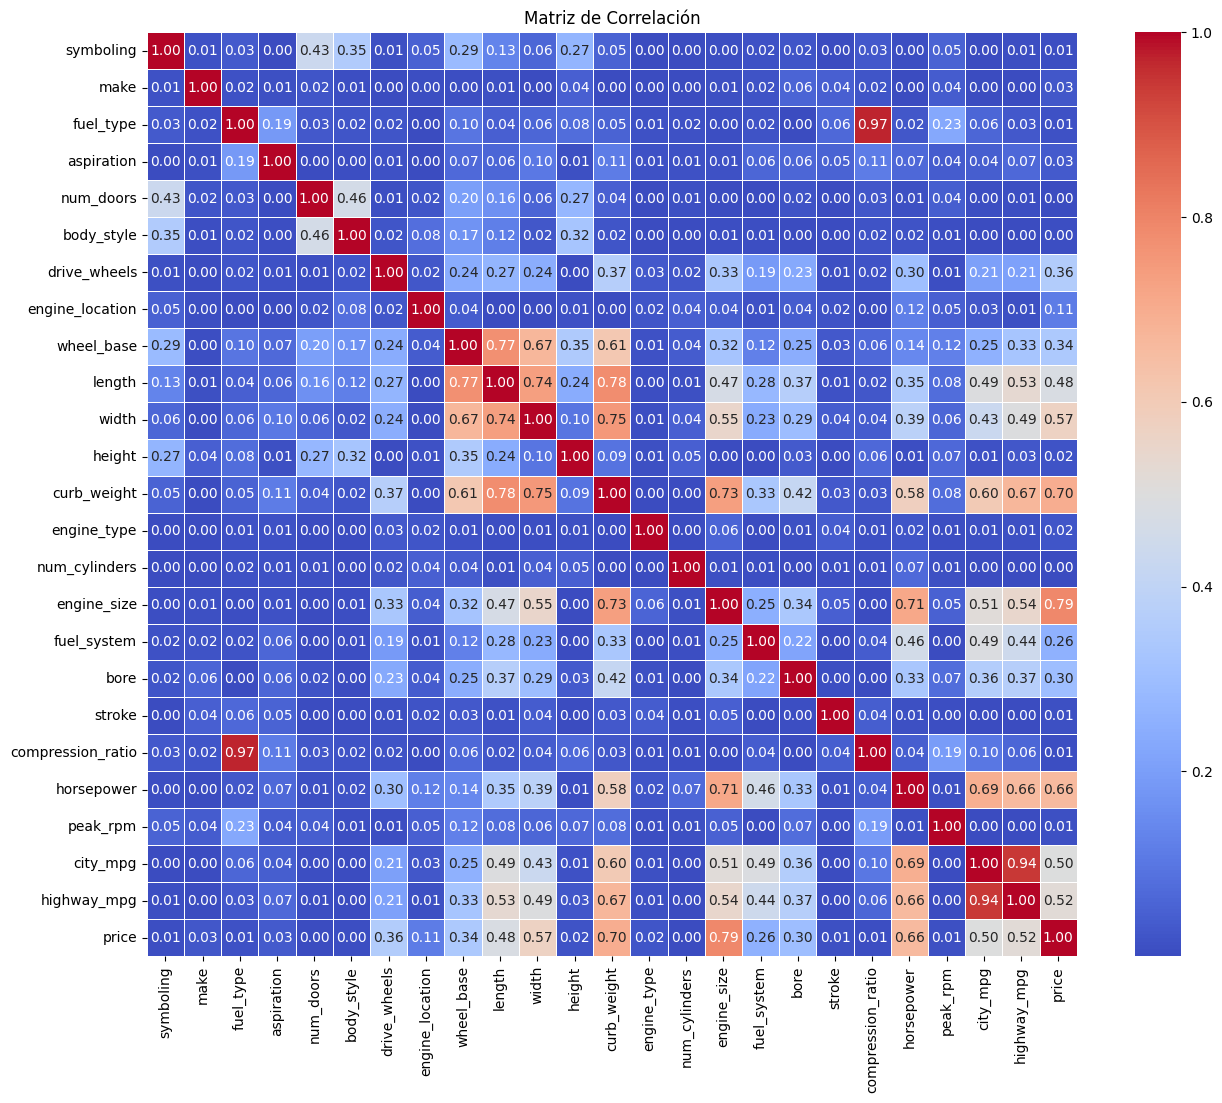

In [228]:
correlation_matrix = df_2.corr()**2

# Crear el mapa de calor de la matriz de correlación
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt="0.2f")

# Mostrar el gráfico
plt.title("Matriz de Correlación")
plt.show()

## Obtener columnas con poca corr

In [229]:
no_corr = correlation_matrix[abs(correlation_matrix['price']) < 0.45].index
no_corr

Index(['symboling', 'make', 'fuel_type', 'aspiration', 'num_doors',
       'body_style', 'drive_wheels', 'engine_location', 'wheel_base', 'height',
       'engine_type', 'num_cylinders', 'fuel_system', 'bore', 'stroke',
       'compression_ratio', 'peak_rpm'],
      dtype='object')

## Eliminamos columnas que tienen poca correlacion con nuestra variable objetivo

In [230]:
df_2_1 = df_2.drop(columns=no_corr, axis=1)
print(df_2_1.columns)

Index(['length', 'width', 'curb_weight', 'engine_size', 'horsepower',
       'city_mpg', 'highway_mpg', 'price'],
      dtype='object')


## Ejecutar modelo

In [231]:
X_2 = df_2_1.drop(columns=['price'])
y_2 = df_2_1['price']

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

ej4_mse = mean_squared_error(y_test, y_pred)
ej4_r2 = r2_score(y_test, y_pred)
ej4_rmse = np.sqrt(ej4_mse)

# print(f'mse: {mse}')
print(f'r2: {ej4_r2}')
print(f'rmse: {ej4_rmse}')

r2: 0.8217418687949553
rmse: 4475.683363937552


# Ej 5. Variables numericas correlativas y normalizadas

In [232]:
df_2 = df.select_dtypes(include=['float64', 'int64'])

## Mostrar correlacion y eliminar las menos correlativas

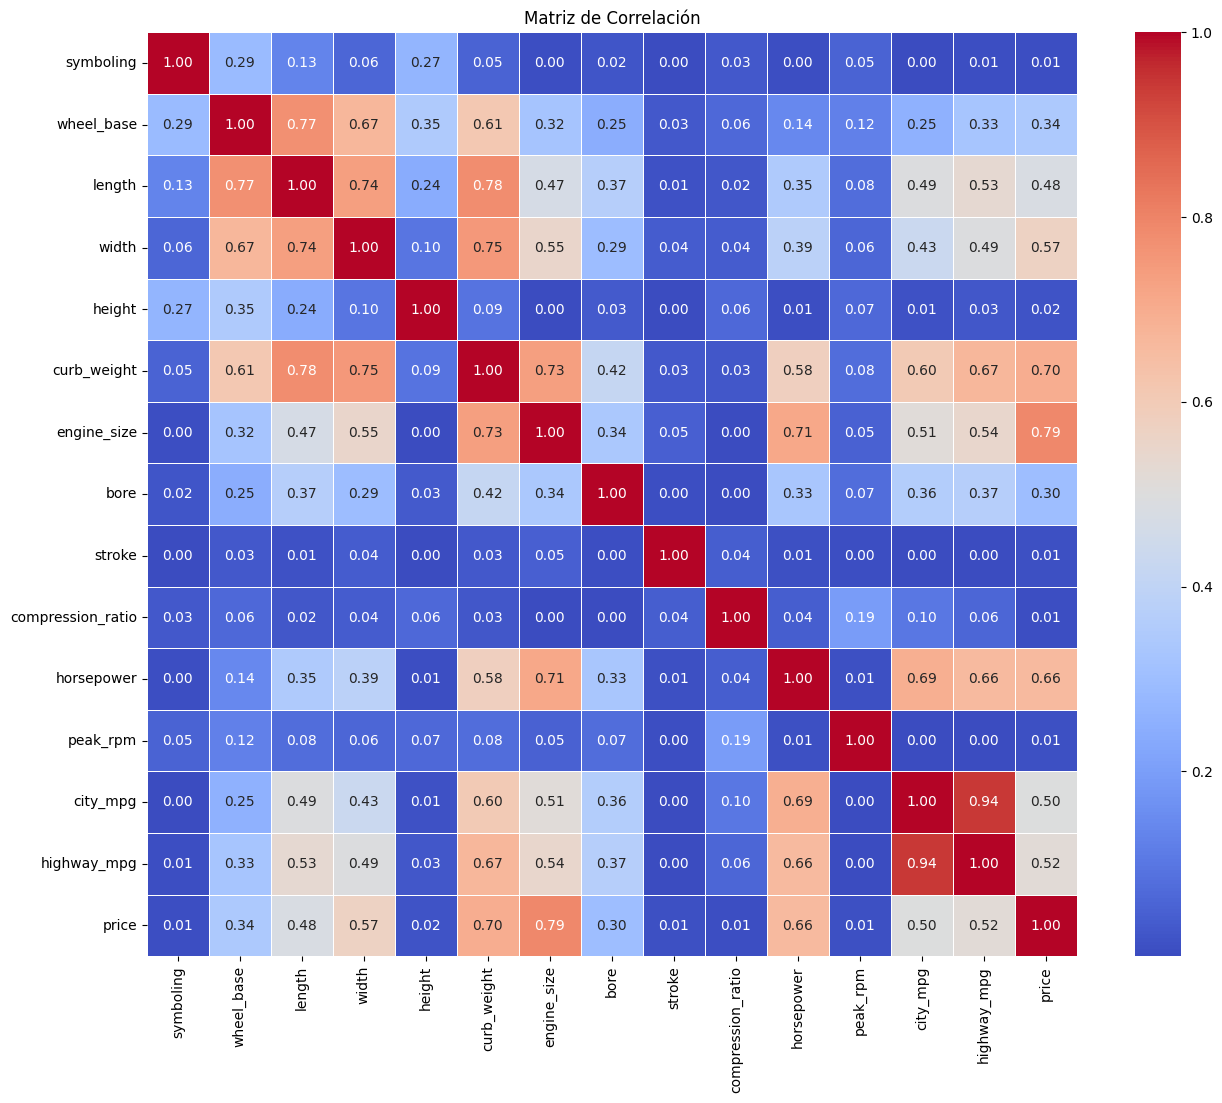

In [233]:
df_2 = df_2.reset_index(drop=True)

columns = df_2.columns.tolist()
columns.remove("price")
df_to_scale = df_2[columns]
df_scaled = pd.DataFrame(scaler.fit_transform(df_to_scale), columns=columns)
df_scaled['price'] = df_2['price']
df_scaled.dropna()

correlation_matrix = df_scaled.corr()**2
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt="0.2f")

plt.title("Matriz de Correlación")
plt.show()

In [234]:
no_corr = correlation_matrix[abs(correlation_matrix['price']) < 0.45].index
no_corr

Index(['symboling', 'wheel_base', 'height', 'bore', 'stroke',
       'compression_ratio', 'peak_rpm'],
      dtype='object')

## Ejecutar modelo

In [235]:
df_2 = df_2.drop(columns=no_corr, axis=1)

X = df_2.drop(columns=['price'])
y = df_2['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

ej5_mse = mean_squared_error(y_test, y_pred)
ej5_r2 = r2_score(y_test, y_pred)
ej5_rmse = np.sqrt(ej5_mse)

# print(f'mse: {mse}')
print(f'r2: {ej5_r2}')
print(f'rmse: {ej5_rmse}')

r2: 0.8217418687949553
rmse: 4475.683363937552


# Resultados

In [236]:
data = {
    "Ejercicio": [1, 2, 3, 4, 5],
    "R2": [ej1_r2, ej2_r2, ej3_r2, ej4_r2, ej5_r2],
    "RMSE": [ej1_rmse, ej2_rmse, ej3_rmse, ej4_rmse, ej5_rmse]
}
resultado = pd.DataFrame(data)
resultado

,Ejercicio,R2,RMSE
0,1,0.849820,4108.098565
1,2,0.821742,4475.683364
2,3,0.849820,4108.098565
3,4,0.821742,4475.683364
4,5,0.821742,4475.683364


Los ejercicios 1 y 3 tienen mejores resultados que los ejercicios 2, 4 y 5, con mayor r2 y menor rmse